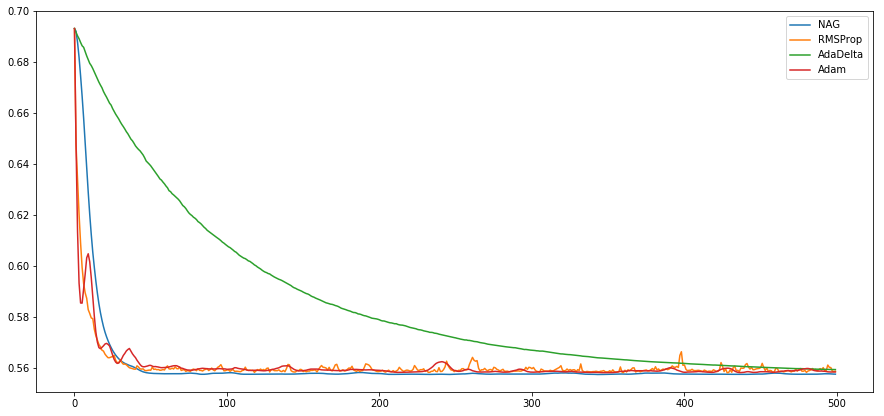

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import math
import random
import time 

X_train,y_train = load_svmlight_file('a9a.txt')
X_test,y_test = load_svmlight_file('a9a.t')
X_train = X_train.toarray()
X_test = X_test.toarray()
apnd = np.zeros(X_test.shape[0]).reshape(X_test.shape[0],1)
X_test  = np.concatenate((X_test,apnd),axis = 1)

def formulate(W,Xi):
	g = 1/(1+math.exp(-1*W.T.dot(Xi)))
	return g


def loss_fun(X,y,W,lam):
	part1 = (lam/2)*W.dot(W)
	part2 = 0
	for i in np.arange(X.shape[0]):
		part2 +=math.log(1+math.exp(-y[i]*( W.T.dot(X[i]) )))
	part2 /= X.shape[0]
	loss = part1 + part2
	return loss

def logistic_pred(train,W):
	prediction = np.zeros(train.shape[0])
	for i in np.arange(len(prediction)):
		pred = formulate(W,train[i])
		prediction[i] = pred
	return prediction
	
	
	
	
def Gradient(X,y,W,lam):
	all =range(X.shape[0])
	sample =random.sample(all,50)
	
	gred = np.zeros(W.shape)
	part1 = lam*W
	part2 = np.zeros(W.shape)
	for i in sample:
		part2 += y[i]*X[i]/(1+math.exp(y[i]*W.T.dot(X[i])))
	part2 /=len(sample)
	gred =part1 - part2
	return gred

def comparsion(X,y,W,lam):
	predict= logistic_pred(X,W)
	prediction = np.zeros(predict.shape)
	#print(len(predict))
	for j in np.arange(len(predict)):
		if predict[j] >= 0.5:
			prediction[j] = 1
		else:
			prediction[j] = -1
	wrong = 0
	for j in np.arange(len(prediction)):
		if prediction[j] != y[j]:
			wrong += 1
	#print('wrong rate: '+ str(float(wrong)/len(prediction)))
	#print('loss :' + str(loss_fun(X,y,W,lam)))
	
	return float(wrong)/len(prediction),loss_fun(X,y,W,lam)
	
	
def NAG(X_train,y_train,X_test,y_test,eta,lam,iterations):
	W = np.zeros(X_train.shape[1])
	V = np.zeros(W.shape)
	gamma = 0.9
	loss_tend = np.zeros(iterations)
	for i in np.arange(iterations):
		wr,loss = comparsion(X_train,y_train,W,lam)
		twr,tlos = comparsion(X_test,y_test,W,lam)
		#print('wrong rate: '+ str(wr))
		#print('loss :' + str(loss))
		#print('test wrong rate: '+ str(twr))
		#print('test loss :' + str(tlos))
		gred = Gradient(X_train,y_train,W,lam)
		
		V = gamma*V + eta*gred
		W = W - V
		loss_tend[i] = loss
	return loss_tend

def RMSProp(X_train,y_train,X_test,y_test,eta,lam,iterations):
	W = np.zeros(X_train.shape[1])
	G = np.zeros(W.shape)
	gamma = 0.9
	el = 10**-8
	loss_tend = np.zeros(iterations)
	for i in np.arange(iterations):
		wr,loss = comparsion(X_train,y_train,W,lam)
		twr,tlos = comparsion(X_test,y_test,W,lam)
		#print('wrong rate: '+ str(wr))
		#print('loss :' + str(loss))
		#print('test wrong rate: '+ str(twr))
		#print('test loss :' + str(tlos))
		gred = Gradient(X_train,y_train,W,lam)
		G = gamma*G + (1-gamma)*gred**2
		part =np.zeros(G.shape)
		for j in np.arange(len(part)):
			part[j] = eta/math.sqrt( G[j]+el )
		W = W - part*gred
		loss_tend[i] = loss
	return loss_tend

def AdaDelta(X_train,y_train,X_test,y_test,lam,iterations):
	W = np.zeros(X_train.shape[1])
	G = np.zeros(W.shape)
	Dt = np.zeros(W.shape)
	el = 10**-8
	gamma =0.95
	
	loss_tend = np.zeros(iterations)
	
	for i in np.arange(iterations):
		wr,loss = comparsion(X_train,y_train,W,lam)
		twr,tlos = comparsion(X_test,y_test,W,lam)
		#print('wrong rate: '+ str(wr))
		#print('loss :' + str(loss))
		#print('test wrong rate: '+ str(twr))
		#print('test loss :' + str(tlos))
		
		gred = Gradient(X_train,y_train,W,lam)
		G = gamma*G + (1-gamma)*gred**2
		part = np.zeros(W.shape)
		for j in np.arange(len(part)):
			part[j] = math.sqrt(Dt[j] + el)/math.sqrt(G[j] + el)
		Dw = -1*part*gred
		W = W + Dw
		Dt = gamma*Dt + (1-gamma)*(Dw**2)
		loss_tend[i] = loss
	return loss_tend
		
		
def Adam(X_train,y_train,X_test,y_test,eta,lam,iterations):
	W = np.zeros(X_train.shape[1])
	G = np.zeros(W.shape)
	M = np.zeros(W.shape)
	B = 0.9
	el = 10**-8
	gamma = 0.999
	
	loss_tend = np.zeros(iterations)
	
	for i in np.arange(iterations):
		wr,loss = comparsion(X_train,y_train,W,lam)
		twr,tlos = comparsion(X_test,y_test,W,lam)
		#print('wrong rate: '+ str(wr))
		#print('loss :' + str(loss))
		#print('test wrong rate: '+ str(twr))
		#print('test loss :' + str(tlos))
		
		gred = Gradient(X_train,y_train,W,lam)
		M = B*M + (1-B)*gred
		G = gamma*G + (1-gamma)*gred**2
		a = eta*math.exp( 1- gamma**i)/math.exp(1-B**i)
		part = np.zeros(W.shape)
		for j in np.arange(len(part)):
			part[j] = M[j]/math.sqrt(G[j] + el)
		W = W - a*part
		loss_tend[i] = loss
	return loss_tend
		
		
	
def logistic_model(X_train,y_train,X_test,y_test,eta,lam,iterations =100):
	NAG_loss = NAG(X_train,y_train,X_test,y_test,eta,lam,iterations)
	RMSProp_loss = RMSProp(X_train,y_train,X_test,y_test,eta,lam,iterations)
	AdaDelta_loss = AdaDelta(X_train,y_train,X_test,y_test,lam,iterations)
	Adam_loss = Adam(X_train,y_train,X_test,y_test,eta,lam,iterations)
	fig = plt.figure(figsize = (15,7))
	ax = fig.add_subplot(111)
	plt.plot(NAG_loss,label = 'NAG')
	plt.plot(RMSProp_loss,label = 'RMSProp')
	plt.plot(AdaDelta_loss,label = 'AdaDelta')
	plt.plot(Adam_loss,label = 'Adam')
	plt.legend(loc = 0)
	plt.show()
logistic_model(X_train,y_train,X_test,y_test,0.005,0.5,500)	
		
	
	
	